### Анализ рентгеновских снимков по картинкам с прогнозированием заболеваний

#### [Ссылка на датасет](https://huggingface.co/datasets/Sohaibsoussi/NIH-Chest-X-ray-dataset-small)

```
class_label:
  '0': No Finding
  '1': Atelectasis
  '2': Cardiomegaly
  '3': Effusion
  '4': Infiltration
  '5': Mass
  '6': Nodule
  '7': Pneumonia
  '8': Pneumothorax
  '9': Consolidation
  '10': Edema
  '11': Emphysema
  '12': Fibrosis
  '13': Pleural_Thickening
  '14': Hernia
```

In [71]:
# !source venv/bin/activate  
# !pip install -r requirements.txt 

In [72]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from datetime import datetime

from torchvision import models

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms.v2 as tfs_v2

In [73]:
PROJECT_DIR_PATH = os.path.abspath(os.path.curdir)
DATASET_DIR_PATH = os.path.join(PROJECT_DIR_PATH, 'dataset')

In [74]:
if ('kaggle/working' in PROJECT_DIR_PATH):
    input_dir = "/kaggle/input/x-ray-pytorch"
    output_dir = "/kaggle/working/dataset"
    
    os.makedirs(output_dir, exist_ok=True)
    
    if not os.path.exists(input_dir):
        raise FileNotFoundError(f'directory {input_dir} not exist')
    
    shutil.copytree(input_dir, output_dir, dirs_exist_ok=True)
    print("Копирование завершено")
    
    

Копирование завершено


In [75]:
class XRayDataset(data.Dataset):
    def __init__(self, path: str, type_file: str, transform=None):
        self.path = path
        self.type_file = type_file
        self.transform = transform

        self.length = 0
        # self.files = []
        # self.targets = []
        self.classes = torch.eye(15)

        not_split_data = self.get_unpack_img()
        files, targets, _length = self.split_data(not_split_data)

        self.df = pd.DataFrame({'path': files, 'target': targets})
        self.length = self.df.shape[0]

    def __getitem__(self, index: int):
        file_path, target = self.df.iloc[index]
        img = Image.open(file_path).convert('RGB')
        
        if (self.transform is not None):
            img = self.transform(img)
        
        return img, self.classes[target]

    def __len__(self):
        return self.length

    def get_unpack_img(self) -> list:
        type_file_path = os.path.join(self.path, self.type_file)

        if os.path.exists(type_file_path):
            shutil.rmtree(type_file_path)

        os.makedirs(type_file_path, exist_ok=True)

        parquet_files = [f for f in os.listdir(self.path) if f.startswith(
            self.type_file) and f.endswith('.parquet')]

        result = []

        for file_name in tqdm(parquet_files, desc=f"Unpacking {self.type_file}"):
            df = pd.read_parquet(os.path.join(self.path, file_name))

            for idx, row in df.iterrows():
                img_path = os.path.join(type_file_path, f"image_{idx}.png")

                if isinstance(row['image']['bytes'], bytes):
                    with open(img_path, 'wb') as f:
                        f.write(row['image']['bytes'])
                # else:
                #     img = Image.fromarray(row['image'])
                #     img.save(img_path)

                result.append((img_path, row['labels']))

        return result

    def split_data(self, not_split_data: list):
        files = []
        targets = []
        length = 0

        for path, labels in not_split_data:
            for target in labels.tolist():
                files.append(path)
                targets.append(int(target))
                length += 1

        return files, targets, length

    def cut_dataframe(self, target: str | int, count: int) -> None:
        rows_to_drop = self.df[self.df['target'] == target].index[:count]
        self.df = self.df.drop(rows_to_drop)
        self.length = self.df.shape[0]

In [76]:
d_test = XRayDataset(DATASET_DIR_PATH, 'test')
d_train = XRayDataset(DATASET_DIR_PATH, 'train')
d_valid = XRayDataset(DATASET_DIR_PATH, 'validation')

Unpacking validation: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


In [77]:
print('TRAIN_DATASET')
print(d_train.df.info(), end='\n\n')
print(d_train.df.target.value_counts())

TRAIN_DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5260 entries, 0 to 5259
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    5260 non-null   object
 1   target  5260 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 82.3+ KB
None

target
0     2489
4      685
3      459
1      431
6      243
5      194
9      165
8      144
13     108
2       77
12      75
11      71
10      61
7       43
14      15
Name: count, dtype: int64


In [78]:
print('VALID_DATASET')
print(d_valid.df.info(), end='\n\n')
print(d_valid.df.target.value_counts())

VALID_DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2079 entries, 0 to 2078
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2079 non-null   object
 1   target  2079 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.6+ KB
None

target
0     995
4     292
1     177
3     168
6      87
5      72
9      59
8      52
13     50
12     30
2      30
11     26
10     18
7      16
14      7
Name: count, dtype: int64


In [79]:
print('TEST_DATASET')
print(d_test.df.info(), end='\n\n')
print(d_test.df.target.value_counts())

TEST_DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828 entries, 0 to 1827
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    1828 non-null   object
 1   target  1828 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 28.7+ KB
None

target
0     541
4     284
3     213
1     160
8     146
5      96
9      77
6      73
11     60
13     55
2      42
10     31
12     26
7      23
14      1
Name: count, dtype: int64


In [ ]:
d_train.cut_dataframe(0, 1300)
d_train.df.target.value_counts()

target
0     1189
4      685
3      459
1      431
6      243
5      194
9      165
8      144
13     108
2       77
12      75
11      71
10      61
7       43
14      15
Name: count, dtype: int64

In [81]:
transform = tfs_v2.Compose([
    tfs_v2.ToTensor(),
    tfs_v2.ToDtype(dtype=torch.float32, scale=True),
    tfs_v2.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

d_train.transform = transform
d_valid.transform = transform
train_data = data.DataLoader(d_train, batch_size=16, shuffle=True)

model = models.vgg16(weights='IMAGENET1K_V1')

for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(25088, 4096), # 512*7*7 = 25088
    nn.ReLU(),
    nn.Linear(4096, 15) 
)

optimizer = optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-3)
# loss_function = nn.BCEWithLogitsLoss()
loss_function = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    if num_gpus > 0:
        model = nn.DataParallel(model)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
modal_start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
os.makedirs(os.path.join(PROJECT_DIR_PATH, 'models',
            'vgg16', modal_start_time), exist_ok=True)

epochs = 5

Q_arr = []
loss_mean_arr = []
torch.cuda.empty_cache()

for _e in range(epochs):
    loss_mean = 0  # среднее значение функции потерь (по эпохе)
    lm_count = 0  # текущее количество слагаемых

    train_tqdm = tqdm(train_data, leave=True)

    for x_train, y_train in train_tqdm:
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        y_pred = model(x_train)
        loss = loss_function(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(
            f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.3f}")
    
    # Validate
    Q = 0
    model.eval()
    valid_data = data.DataLoader(d_valid, batch_size=20, shuffle=False)
    valid_tqmd = tqdm(valid_data, leave=True)

    for x_valid, y_valid in valid_tqmd:
        with torch.no_grad():
            x_valid= x_valid.to(device)
            y_valid = y_valid.to(device)
            
            logits = model(x_valid)
            
            y_valid = torch.argmax(y_valid, dim=1)
            y_pred = torch.argmax(logits, dim=1)
            
            Q += torch.sum(y_valid == y_pred).item()
    
    Q /= len(d_valid)
    
    Q_arr.append(Q)
    loss_mean_arr.append(loss_mean)
    
    model.train()

    model_state_dict = {
        'tfs': transform.state_dict(),
        'opt': optimizer.state_dict(),
        'model': model.module.state_dict() if num_gpus > 1 else model.state_dict(),
        'epochs': _e + 1,
        'accuracy_arr': Q_arr,
        'loss_mean_arr': loss_mean_arr,
    }

    torch.save(model_state_dict,
               f"./models/vgg16/{modal_start_time}/epoch_{_e + 1}.tar")
    

100%|██████████| 104/104 [03:29<00:00,  2.02s/it]


In [94]:
ep = [i + 1 for i in range(epochs)]

In [95]:
print('ep = ', ep)
print('Q_arr = ', Q_arr)
print('loss_mean_arr = ', loss_mean_arr)

ep =  [1, 2, 3, 4, 5]
Q_arr =  [0.47619047619047616, 0.4785954785954786, 0.4785954785954786, 0.4627224627224627, 0.4785954785954786]
loss_mean_arr =  [2.4268433307447745, 2.203715022533172, 2.1796190854041817, 2.1647101318643958, 2.1388029196570026]


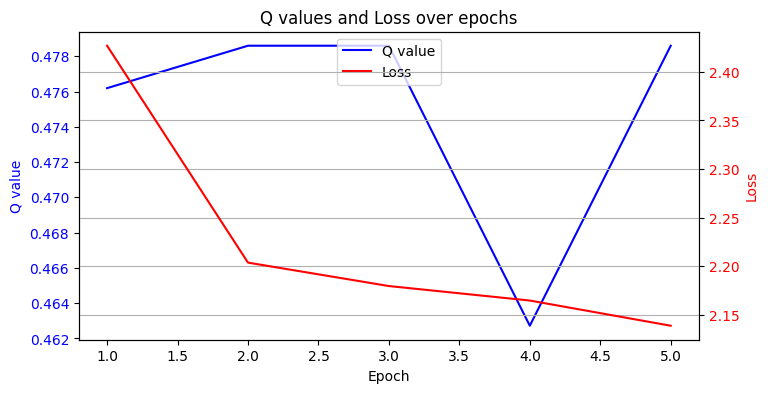

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Q value', color='b')
line1 = ax1.plot(ep, Q_arr, color='b', label='Q value')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='r')
line2 = ax2.plot(ep, loss_mean_arr, color='r', label='Loss')
ax2.tick_params(axis='y', labelcolor='r')

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper center')

plt.title('Q values and Loss over epochs')
plt.grid(True)
plt.show()

```py
# weights_only=True означает, что выполняется загрузка примитивных типов данных, например: словарей, тензоров, списков, строк и т.п. 
model_data = torch.load('model_name.tar', weights_only=True)
model.load_state_dict(model_data['model'])
transforms.load_state_dict(model_data['tfs'])
optimizer.load_state_dict(model_data['opt'])

```